In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_df.info(), test_df.info(), submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


(None, None, None)

In [60]:
# Mã đề: 2251262607 % 7 + 1 = 5 ---> Friday
train_df = train_df[train_df['Publication_Day'] == 'Friday']

In [61]:
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
31,31,Global News,Episode 92,118.15,News,86.22,Friday,Morning,64.88,2.0,Neutral,57.48380
34,34,Study Sessions,Episode 30,8.66,Education,49.75,Friday,Morning,NaN,3.0,Neutral,6.67525
35,35,Sport Spot,Episode 63,75.02,Sports,95.89,Friday,Night,59.71,0.0,Positive,40.33025
58,58,Sports Central,Episode 33,31.90,Sports,63.61,Friday,Evening,64.38,1.0,Negative,19.28000
83,83,Sports Central,Episode 80,25.34,Sports,53.30,Friday,Evening,NaN,3.0,Positive,23.71495
...,...,...,...,...,...,...,...,...,...,...,...,...
749946,749946,Current Affairs,Episode 14,68.06,News,83.39,Friday,Evening,20.08,3.0,Neutral,40.11839
749956,749956,Health Hour,Episode 100,86.21,Health,79.88,Friday,Evening,4.38,1.0,Positive,66.07216
749962,749962,Tune Time,Episode 61,111.23,Music,86.40,Friday,Night,90.18,1.0,Positive,76.05000
749973,749973,Joke Junction,Episode 73,13.67,Comedy,46.31,Friday,Evening,64.91,0.0,Negative,8.37521


In [78]:
train_df.isnull().sum()
# Xem các giá trị bị thiếu

,0
id,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,0
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,0
Number_of_Ads,0


In [63]:
# Nhận thấy được cột target ở đây không có giá trị thiếu, nhưng 2 cột Episode_Length_minutes, Guest_Popularity_percentage bị thiếu rất nhiều
# Có 2 hướng xử lý đầu tiên bọn em sẽ bỏ các giá trị thiếu trước

train_df.dropna(inplace=True)

In [64]:
train_df.isnull().sum()

,0
id,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,0
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,0
Number_of_Ads,0


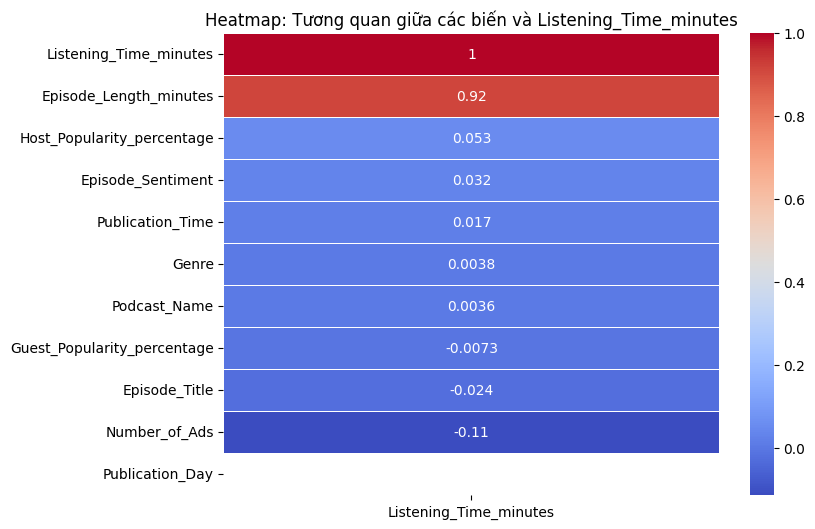

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sao chép và loại bỏ các cột không cần thiết cho phân tích ban đầu
train_df_filtered = train_df.drop(columns=["id"])

# Tạm thời loại bỏ các hàng có giá trị thiếu để phân tích tương quan
train_df_clean = train_df_filtered.dropna()

# Encode các cột phân loại để tính tương quan
from sklearn.preprocessing import LabelEncoder

label_cols = train_df_clean.select_dtypes(include="object").columns
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    train_df_clean[col] = le.fit_transform(train_df_clean[col])
    label_encoders[col] = le

# Tính ma trận tương quan với target
correlation_matrix = train_df_clean.corr(numeric_only=True)
correlation_with_target = correlation_matrix["Listening_Time_minutes"].sort_values(ascending=False)


plt.figure(figsize=(8, 6))
sns.heatmap(train_df_clean.corr(numeric_only=True)[["Listening_Time_minutes"]].sort_values(by="Listening_Time_minutes", ascending=False),
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap: Tương quan giữa các biến và Listening_Time_minutes")
plt.show()


MSE: 706.255839807359
MAE: 22.764278681785623


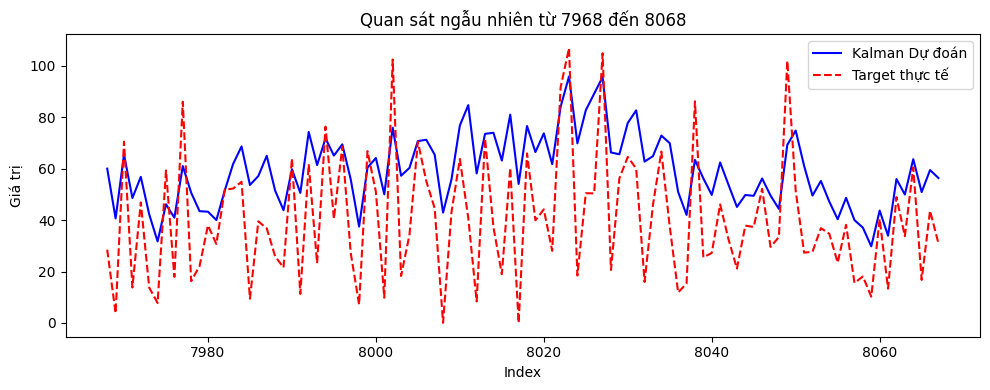

In [66]:
import random

# Dữ liệu đầu vào
data = train_df['Episode_Length_minutes'].dropna().values
target = train_df['Listening_Time_minutes'].dropna().values

# Đảm bảo độ dài bằng nhau
min_len = min(len(data), len(target))
data = data[:min_len]
target = target[:min_len]

# Kalman Filter
n = len(data)
x_est = [0] * n
P = [0] * n
Q = 1
R = 4

x_est[0] = data[0]
P[0] = 1

for t in range(1, n):
    x_pred = x_est[t-1]
    P_pred = P[t-1] + Q

    K = P_pred / (P_pred + R)
    x_est[t] = x_pred + K * (data[t] - x_pred)
    P[t] = (1 - K) * P_pred

# Tính MSE và MAE
x_est = np.array(x_est)
mse = np.mean((target - x_est) ** 2)
mae = np.mean(np.abs(target - x_est))

print("MSE:", mse)
print("MAE:", mae)


segment_length = 100
start = random.randint(0, n - segment_length)
end = start + segment_length

plt.figure(figsize=(10, 4))
plt.plot(range(start, end), x_est[start:end], label='Kalman Dự đoán', color='blue')
plt.plot(range(start, end), target[start:end], label='Target thực tế', color='red', linestyle='dashed')
plt.title(f'Quan sát ngẫu nhiên từ {start} đến {end}')
plt.xlabel('Index')
plt.ylabel('Giá trị')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
# Mô hình kalman là một bộ lọc tuyến tính dùng để ước lượng trạng thái của một hệ thống động theo thời gian
# Nhưng với data trên em không biết được timestamp của data trên là gì!
# Với 1 mô hình kalman không có yếu tố thời gian chắc chán hiệu quả sẽ không cao với việc dự đoán trạng thái tương lai chỉ có hiệu quả với việc giảm nhiễu
# Ở mô hình kalman cơ bản trên yếu tố timestamp được nó set là thứ tự từ 0 đến len(data) nên việc dự báo chắc chắn không hiệu quả

In [68]:
# Theo yếu tố nhận xét trên em cân nhắc việc sử dụng kalman với xu hướng và mùa vụ
# Dù không có dữ liệu theo thời gian, mô hình hóa một số thành phần xu hướng (trend) hoặc biến động có tính chu kỳ (seasonality)
# Hiểu đơn giản ra Xu hướng ở đây là kiểu như dữ liêu tăng dần, giảm dần còn về Chu kỳ là kiểu như lúc nào nó thay đổi tăng giảm
# Mặc dù các yếu tố này cũng bị ảnh hưởng rất lớn bảo timestamp nhưng suy cho cùng mô hình vẫn có thể tận dụng 2 thuộc tính trên

MSE: 624.965149722591
MAE: 21.543346067139904


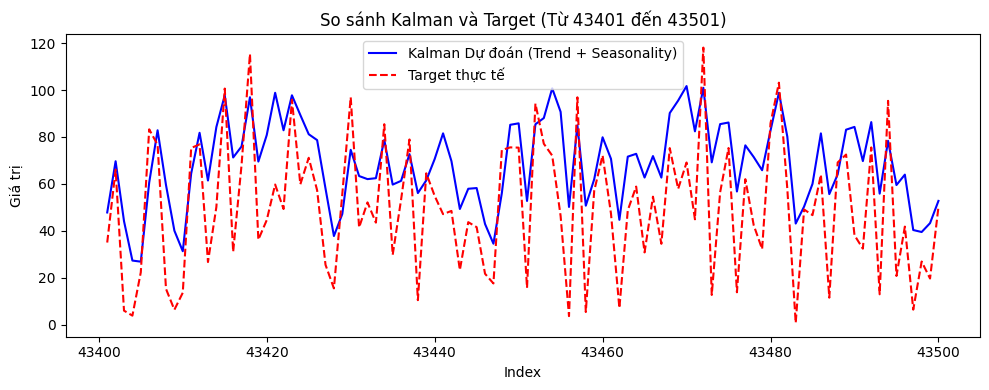

In [69]:
# Khởi tạo Kalman Filter với xu hướng + chu kỳ
x_est = np.zeros((n, 2))     # [trend, seasonality]
P = np.zeros((n, 2, 2))
Q = np.array([[1, 0], [0, 1]])   # Nhiễu hệ thống
R = 4                            # Nhiễu đo lường

# Giá trị khởi tạo
x_est[0] = [data[0], 0]      # Ban đầu: trend = data[0], seasonality = 0
P[0] = np.eye(2)

# Kalman Filter
for t in range(1, n):
    # Dự báo
    x_pred = x_est[t-1]
    P_pred = P[t-1] + Q

    # Quan sát = trend + seasonality
    H = np.array([1, 1])
    z_pred = np.dot(H, x_pred)

    # Kalman Gain
    S = np.dot(H, np.dot(P_pred, H)) + R
    K = np.dot(P_pred, H) / S

    # Cập nhật
    x_est[t] = x_pred + K * (data[t] - z_pred)
    P[t] = (np.eye(2) - np.outer(K, H)) @ P_pred

# Dự đoán cuối cùng
x_total = x_est[:, 0] + x_est[:, 1]

# Tính sai số
mse = np.mean((target - x_total) ** 2)
mae = np.mean(np.abs(target - x_total))

print("MSE:", mse)
print("MAE:", mae)

segment_length = 100
start = random.randint(0, n - segment_length)
end = start + segment_length

plt.figure(figsize=(10, 4))
plt.plot(range(start, end), x_total[start:end], label='Kalman Dự đoán (Trend + Seasonality)', color='blue')
plt.plot(range(start, end), target[start:end], label='Target thực tế', color='red', linestyle='dashed')
plt.title(f'So sánh Kalman và Target (Từ {start} đến {end})')
plt.xlabel('Index')
plt.ylabel('Giá trị')
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
# Có thể thấy rõ MSE đã giảm đáng kể so với mô hình kalman thông thường

In [91]:
# Một mô hình khác của kalman là Extended Kalman Filter (ekf)
# Là phiên bản mở rộng của Kalman Filter, được sử dụng khi hệ thống và hàm quan sát là không tuyến tính
# Các hàm chuyển trạng thái và hàm quan sát được tuyến tính hóa thông qua việc sử dụng khai triển taylor bậc nhất
# Dự báo (Prediction): Giống như KF, nhưng với việc sử dụng các phương trình không tuyến tính, ta phải tính toán đạo hàm của các hàm này để tạo ra ma trận Jacobian.
# Cập nhật (Update): Cập nhật trạng thái ước lượng và phương sai giống như trong KF, nhưng với các phép toán tuyến tính hóa bằng ma trận Jacobian.
# Ma trận Jacobian là ma trận đạo hàm riêng bậc nhất của từng hàm và từng biến
# EKF khắc phục hàm quan sát là không tuyến tính bằng cách xấp xỉ tuyến tính bằng công thức taylor bậc nhất(hàm quan sát h)

MSE: 2.630, MAE: 1.086


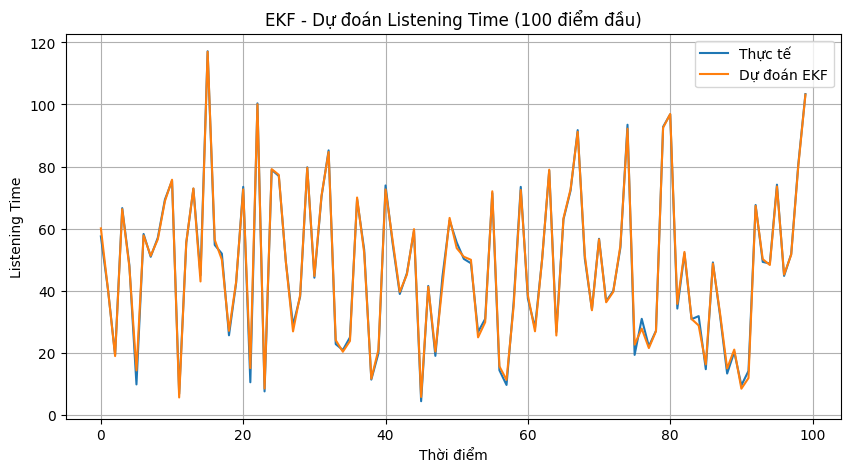

In [71]:

# Dữ liệu
n = len(data)

# Khởi tạo
x_est = np.zeros((n, 2))  # a, b
P = np.zeros((n, 2, 2))
Q = np.array([[1e-2, 0], [0, 1e-2]])  # nhiễu hệ thống
R = 4                                 # nhiễu đo lường

# Giá trị khởi tạo
x_est[0] = [0.5, 1.0]  # hệ số ban đầu
P[0] = np.eye(2)

# EKF
for t in range(1, n):
    # DỰ BÁO
    x_pred = x_est[t-1]
    P_pred = P[t-1] + Q

    # HÀM QUAN SÁT H(x)
    a, b = x_pred
    z_pred = a * data[t] + b**2

    # JACOBIAN H_t
    H_t = np.array([
        [data[t], 2 * b]
    ])

    # KALMAN GAIN
    S = H_t @ P_pred @ H_t.T + R
    K = P_pred @ H_t.T / S

    # CẬP NHẬT
    y_t = target[t]
    x_est[t] = x_pred + (K.flatten() * (y_t - z_pred))
    P[t] = (np.eye(2) - K @ H_t) @ P_pred

# Dự đoán Listening Time từ trạng thái ước lượng
predicted = x_est[:, 0] * data + x_est[:, 1]**2

# Đánh giá
mse = np.mean((target - predicted)**2)
mae = np.mean(np.abs(target - predicted))
print(f"MSE: {mse:.3f}, MAE: {mae:.3f}")

# Vẽ biểu đồ
plt.figure(figsize=(10,5))
plt.plot(target[:100], label='Thực tế')
plt.plot(predicted[:100], label='Dự đoán EKF')
plt.legend()
plt.title("EKF - Dự đoán Listening Time (100 điểm đầu)")
plt.xlabel("Thời điểm")
plt.ylabel("Listening Time")
plt.grid(True)
plt.show()


In [79]:
test_df.dropna(inplace=True)

In [80]:
# Áp dụng mô hình EKF vào tập test mà không so sánh với target
test_df = test_df[test_df['Publication_Day'] == 'Friday']
data_test = test_df['Episode_Length_minutes'].dropna().values

    Episode_Length_minutes  Listening_Time_minutes
2                    69.10               33.716185
6                   116.09              114.456075
8                    92.69               92.633528
17                   47.97               47.965871
21                   81.57               81.569630
27                   39.36               39.360025
36                   22.43               22.430107
44                   71.47               71.469952
74                   60.09               60.090005
77                   18.90               18.900206


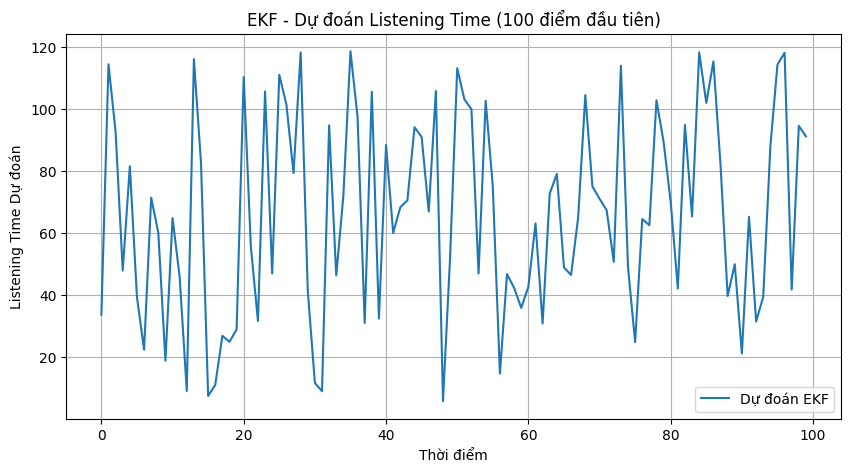

In [84]:
# Khởi tạo các giá trị ban đầu
n_test = len(data_test)  # số lượng điểm dữ liệu trong test set
x_est_test = np.zeros((n_test, 2))  # Khởi tạo mảng cho các tham số a, b của dữ liệu test
P_test = np.zeros((n_test, 2, 2))  # Ma trận phương sai cho dữ liệu test
Q = np.array([[1e-2, 0], [0, 1e-2]])  # Nhiễu hệ thống
R = 4  # Nhiễu đo lường

# Sử dụng giá trị ước lượng cuối cùng từ mô hình huấn luyện
x_est_test[0] = x_est[-1]
P_test[0] = P[-1]

# Dự báo trên dữ liệu test
predicted_test = np.zeros(n_test)  # Mảng lưu kết quả dự đoán

for t in range(1, n_test):
    # === DỰ BÁO ===
    x_pred = x_est_test[t-1]
    P_pred = P_test[t-1] + Q

    # === HÀM QUAN SÁT H(x) ===
    a, b = x_pred
    z_pred = a * data_test[t] + b**2

    # === JACOBIAN H_t ===
    H_t = np.array([ [data_test[t], 2 * b] ])

    # === KALMAN GAIN ===
    S = H_t @ P_pred @ H_t.T + R
    K = P_pred @ H_t.T / S

    # === CẬP NHẬT ===
    # Cập nhật x_est_test[t] và P_test[t]
    x_est_test[t] = x_pred + (K.flatten() * (data_test[t] - z_pred))
    P_test[t] = (np.eye(2) - K @ H_t) @ P_pred

    # Dự đoán Listening Time từ trạng thái ước lượng
    predicted_test[t] = x_est_test[t][0] * data_test[t] + x_est_test[t][1]**2

# Dự đoán cho toàn bộ dữ liệu test
predicted_test_full = x_est_test[:, 0] * data_test + x_est_test[:, 1]**2

# Đảm bảo độ dài của predicted_test_full khớp với số lượng dòng trong test_df
test_df = test_df.iloc[:n_test].copy()  # Giới hạn test_df với số dòng khớp với data_test
test_df['Listening_Time_minutes'] = predicted_test_full  # Gán giá trị dự đoán vào cột mới

# Vẽ biểu đồ chỉ hiển thị dự đoán EKF
plt.figure(figsize=(10, 5))
plt.plot(predicted_test_full[:100], label='Dự đoán EKF')
plt.legend()
plt.title("EKF - Dự đoán Listening Time (100 điểm đầu tiên)")
plt.xlabel("Thời điểm")
plt.ylabel("Listening Time Dự đoán")
plt.grid(True)
plt.show()


In [85]:
print(test_df[['Episode_Length_minutes', 'Listening_Time_minutes']].head(10))

    Episode_Length_minutes  Listening_Time_minutes
2                    69.10               33.716185
6                   116.09              114.456075
8                    92.69               92.633528
17                   47.97               47.965871
21                   81.57               81.569630
27                   39.36               39.360025
36                   22.43               22.430107
44                   71.47               71.469952
74                   60.09               60.090005
77                   18.90               18.900206


In [86]:
test_subset = test_df[['id', 'Listening_Time_minutes']].rename(columns={'Listening_Time_minutes': 'Listening_Time_minutes_kalman'})

# Thực hiện merge, sử dụng 'how='left'' để giữ tất cả các hàng trong 'submiss'
submission_df = pd.merge(submission_df, test_subset, on='id', how='left')

In [88]:
submission_df.dropna(inplace=True)

In [89]:
submission_df

,id,Listening_Time_minutes,Listening_Time_minutes_kalman
2,750002,45.437,33.716185
6,750006,45.437,114.456075
8,750008,45.437,92.633528
17,750017,45.437,47.965871
21,750021,45.437,81.569630
...,...,...,...
221349,971349,45.437,118.370000
221355,971355,45.437,28.360003
221369,971369,45.437,99.719999
221372,971372,45.437,53.980001


from matplotlib import pyplot as plt
submission_df['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['Listening_Time_minutes_kalman'].plot(kind='hist', bins=20, title='Listening_Time_minutes_kalman')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='id', y='Listening_Time_minutes_kalman', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Listening_Time_minutes_kalman']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission_df.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Listening_Time_minutes_kalman')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission_df.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Listening_Time_minutes']
  ys = series['Listening_Time_minutes_kalman']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission_df.sort_values('Listening_Time_minutes', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Listening_Time_minutes')
_ = plt.ylabel('Listening_Time_minutes_kalman')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Listening_Time_minutes']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Listening_Time_minutes'}, axis=1)
              .sort_values('Listening_Time_minutes', ascending=True))
  xs = counted['Listening_Time_minutes']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission_df.sort_values('Listening_Time_minutes', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Listening_Time_minutes')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
submission_df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission_df['Listening_Time_minutes_kalman'].plot(kind='line', figsize=(8, 4), title='Listening_Time_minutes_kalman')
plt.gca().spines[['top', 'right']].set_visible(False)

In [90]:
submission_df.to_csv('submission.csv', index=False)